In [1]:
from __future__ import division
#import numpy as np
from autograd import numpy as np
from autograd import grad
from matplotlib import pyplot as plt
import seaborn
import scipy
%matplotlib inline

# Density Function

In [2]:
# Density function for distribution for both MCMC algorithms
# has two modes separated by a region of low probability.
def p( x, t=1.0 ):
    return np.exp( -10*t*((x-2)**2) ) + 0.3*np.exp( -0.5*10*t*((x+1)**2) )

# Part 1: Metropolis Hastings



Running Metropolis Hastings with Variance =  0.1


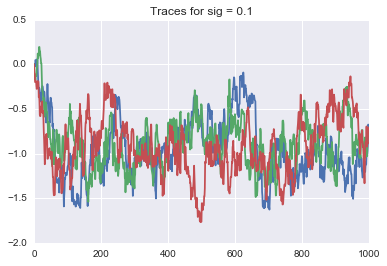

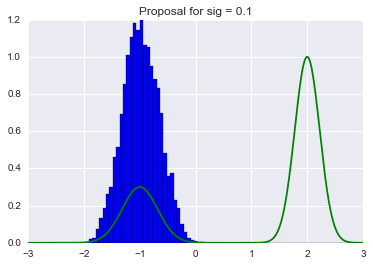

Acceptance Rate for Variance =  0.1 :  89.36 %


Running Metropolis Hastings with Variance =  1.0


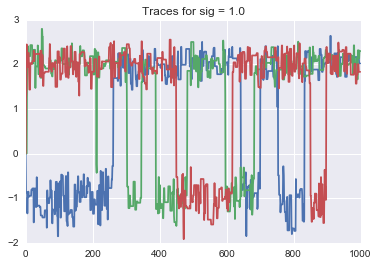

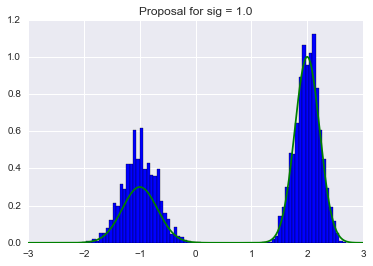

Acceptance Rate for Variance =  1.0 :  30.28 %


Running Metropolis Hastings with Variance =  10.0


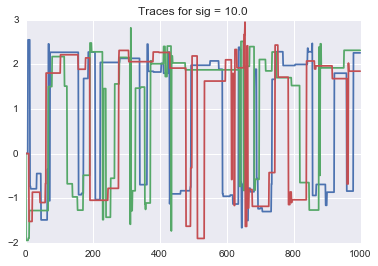

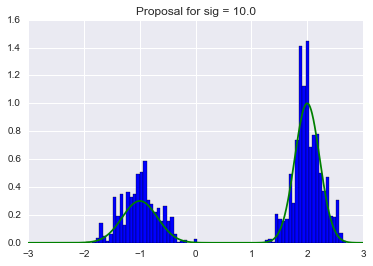

Acceptance Rate for Variance =  10.0 :  5.58 %


In [3]:
def run_mcmc(n,sig):
    """
    Run the Metropolis Hastings Algorithm for n time steps
    with variance = sig.
    """
    x_states = np.zeros(n)
    accepted = 0
    
    for t in xrange(n-1):
        # Define x as xt
        x = x_states[t]

        # Sample x' from q(x'|x)
        xp = np.random.normal(x, sig)

        # Compute acceptance probability alpha = p(x')*q(x|x')/p(x)q(x'|x)
        alpha = p(xp)/p(x)

        # Compute r = min(1, alpha)
        r = min(1,alpha)

        # Sample u from U(0,1) 
        u = np.random.uniform(0,1)
        
        # Set new sample x_t+1 = (x' if u<r or xt if >= r)
        if u < r:
            x_states[t+1] = xp
            accepted += 1
            
        elif u >= r:
            x_states[t+1] = x
            
    return x_states, accepted

# Run Metropolis Hastings for each variance
for sig in [0.1, 1.0, 10.0]:
    print "\n\nRunning Metropolis Hastings with Variance = ", sig
    
    for i in xrange(3):
        x_states, acceptance = run_mcmc(1000,sig)
        plt.plot(x_states)
    plt.title('Traces for sig = ' + str(sig))
    plt.show()

    proposal_states, acceptance = run_mcmc(10000,sig)
    domain = np.linspace(-3,3,1000)
    
    plt.hist(proposal_states,np.linspace(-3,3,100)[:-1],normed=True,color='blue')
    plt.plot(domain, p(domain),color='green')
    
    plt.title('Proposal for sig = ' + str(sig))
    plt.show()
    
    print "Acceptance Rate for Variance = ", sig, ": ", acceptance/100, "%"

# Hamiltonian MCMC


In [18]:
def hmc(U, grad_U, epsilon, L, current_q, sig):
    
    q = current_q
    # p = rnorm(length(q),0,1) # independent standard normal variates
    p = np.random.normal(scale=sig)
    current_p = p
    
    # Half step for momentum at the beginning
    p -=  epsilon * grad_U(q)/2
    
    # Alternate full steps for position and momentum
    for i in xrange(L):
        
        # Full step for position
        q += epsilon*p 
        
        # Full step for momentum, except at the end
        if i < L-1:
            p -= epsilon * grad_U(q)
            
    # Half step for momentum at the end
    p -= epsilon * grad_U(q)/2
    
    # Negate to make proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    #current_K = sum(current_p**2) / 2
    current_K = current_p**2 / 2
    proposed_U = U(q)
    #proposed_K = sum(p**2) / 2
    proposed_K = p**2 / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    
    to_accept = current_U - proposed_U + current_K - proposed_K
    
    if np.random.uniform() < np.exp(to_accept):
        return q, 1  # Accept
    else:
        return current_q, 0 # Reject
    
def run_hmc(sig, dt):
    """
    Run the Hamiltonian MCMC test using sig for the variance and dt for the
    timestep.
    """
    def U(q):
        return -np.log(p(q))
    
    L = 100
    epsilon = dt
    q = np.zeros(1000)
    
    for i in xrange(3):
        q_track = np.zeros(1000)
        for t in xrange(999):
            q_track[t+1], accepted = hmc(U, grad(U), epsilon, L, q_track[t], sig)
        plt.plot(q_track)
    plt.title('Trace of the particle')
    plt.show()
    
    acceptances = 0
    for t in xrange(999):
        q[t+1], accepted = hmc(U, grad(U), epsilon, L, q[t], sig)
        acceptances += accepted
    
    domain = np.linspace(-3,3,1000)
    plt.hist(q, np.linspace(-3,3,100)[:-1], normed=True, color='blue')
    plt.plot(domain, p(domain), color='green')
    
    plt.title('Proposal for sig = ' + str(sig) + ' and dt = ' + str(dt))
    plt.show()
    
    print "Acceptance Rate = ", acceptances/10, "%"

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


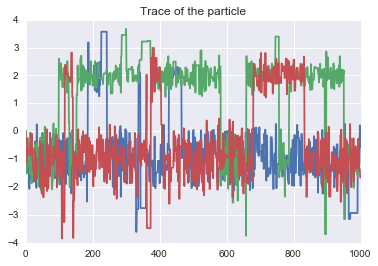

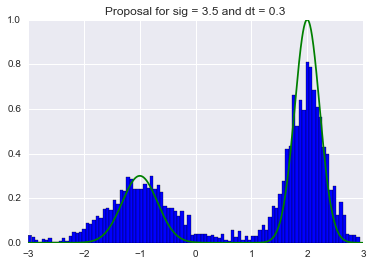

Acceptance Rate =  52.53 %


In [16]:
# Run the values found to be best for 10,000 steps
run_hmc(3.5, 0.3)

# Observations

Testing results used to determine the optimal value for momentum variance and time step for the Hamiltonian MCMC are included below. Each was run for only
1000 time steps, but with L=100 as in the full algorithm.

* What was the acceptance rate of each Algorithm?

For Metropolis Hastings, the acceptance rate was 89.36% with a variance of 0.1, 30.28% with a variance of 1.0, and 5.58% with a variance of 10.0. 

For the Hamiltonian MCMC, the acceptance rate was 52.53% for a variance of 3.5 and a time step of 0.3.

* Why don't some inference algorithms explore both modes of the density?

If the variance is low enough, the probability of the particle moving enough to cross over to the other mode is very low, and it never moves to the other mode.

* Why do some algorithms stay in the state repeatedly?

If the acceptance rate is low, the particle will stay in the same state repeatedly, creating a choppy-looking proposal distribution.

* What were the best values for the variance of the momentum values and the
   timestep that you found? How did you know that they were good?
   
For the Metropolis Hastings algorithm, the best value tried was 1.0. We know it is the best value since when the algorithm is run for a fairly high number of trials, the normalized histogram of the results most closely matches the probability distribution.

For the Hamiltonian, we investigated various values for the variance of the momentum and for the time step, and found the best approximation of the probability distribution at sig = 3.5 and dt = 0.3. When sig or dt was too low, the acceptance rate was so high that the particle bounced around too much and never stayed anywhere, creating a flattened-out proposal distribution. When sig or dt was too high, the acceptance rate was so low that the particle didn't move enough to properly explore both modes, creating a choppy-looking proposal distribution without proper exploration of both modes.


Running Hamiltonian MCMC with Variance  1  and Timestep  0.25


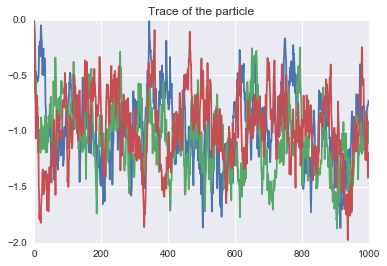

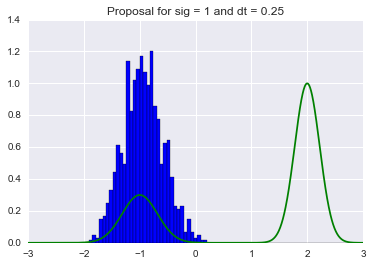

Acceptance Rate =  97.1 %

Running Hamiltonian MCMC with Variance  1  and Timestep  0.5


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


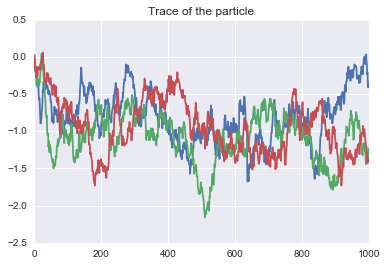

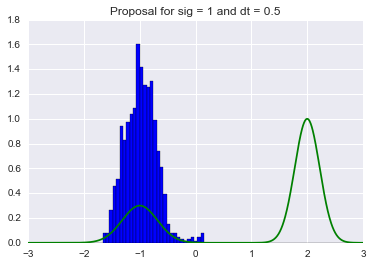

Acceptance Rate =  97.7 %

Running Hamiltonian MCMC with Variance  1  and Timestep  0.75


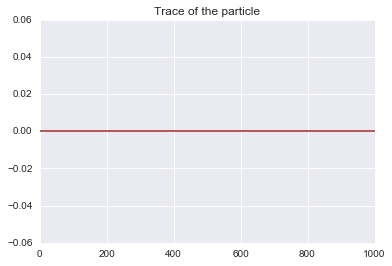

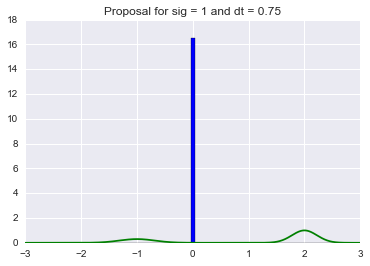

Acceptance Rate =  0.0 %

Running Hamiltonian MCMC with Variance  2  and Timestep  0.25


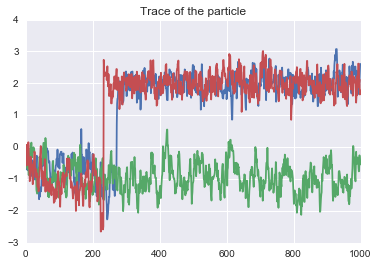

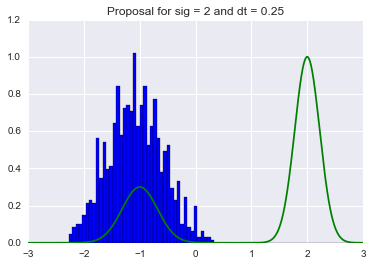

Acceptance Rate =  90.9 %

Running Hamiltonian MCMC with Variance  2  and Timestep  0.5


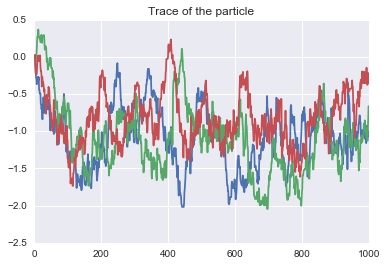

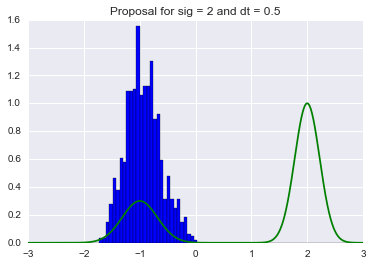

Acceptance Rate =  82.9 %

Running Hamiltonian MCMC with Variance  2  and Timestep  0.75


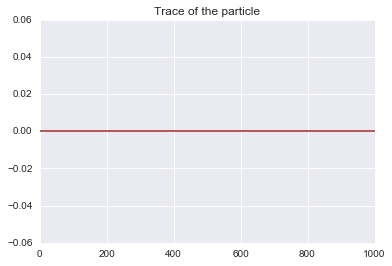

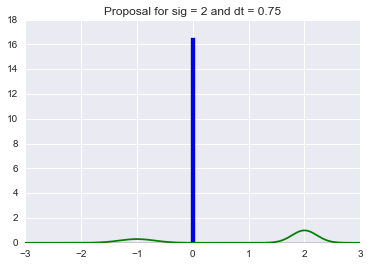

Acceptance Rate =  0.0 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.25


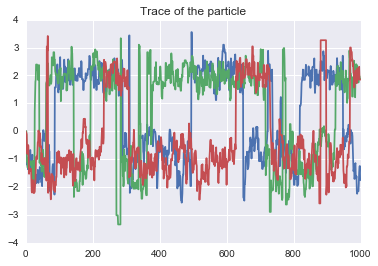

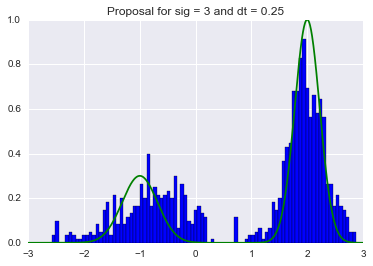

Acceptance Rate =  71.6 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.5


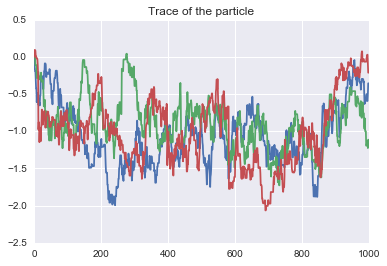

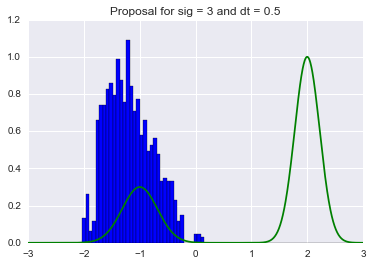

Acceptance Rate =  61.5 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.75


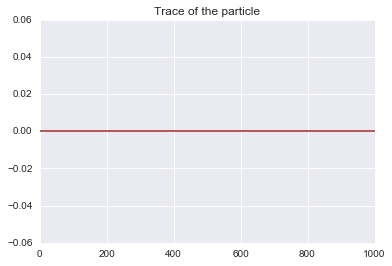

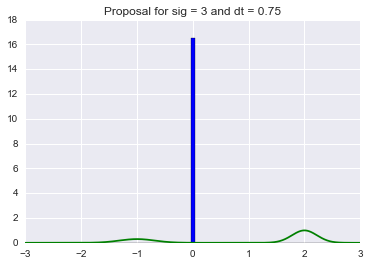

Acceptance Rate =  0.0 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.25


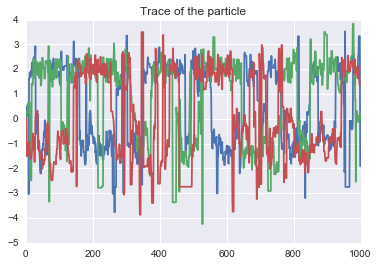

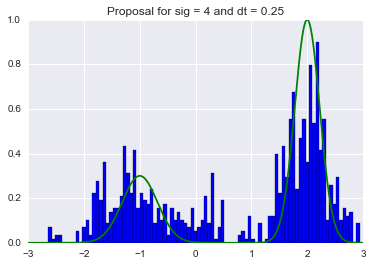

Acceptance Rate =  58.6 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.5


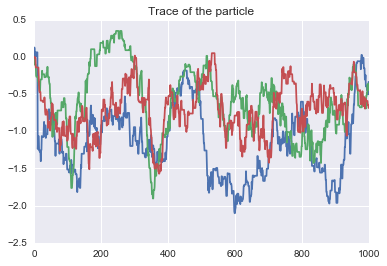

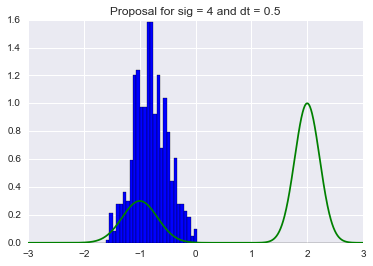

Acceptance Rate =  51.1 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.75


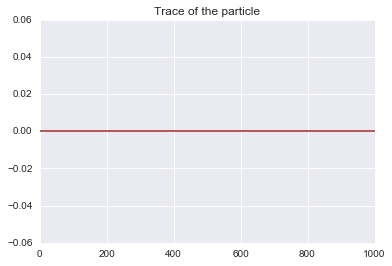

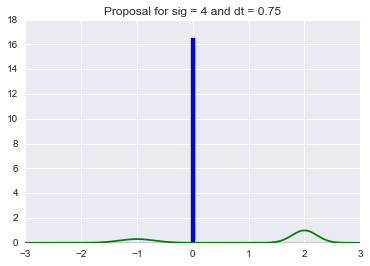

Acceptance Rate =  0.0 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.25


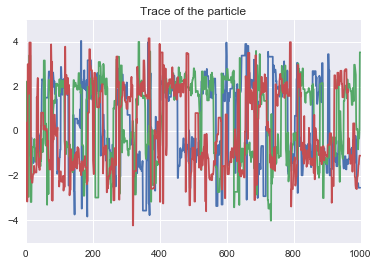

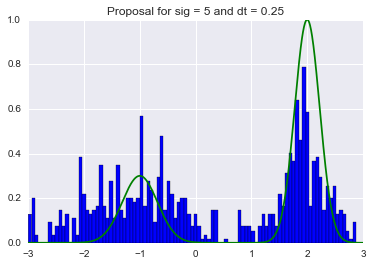

Acceptance Rate =  51.3 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.5


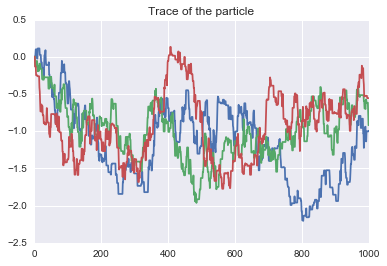

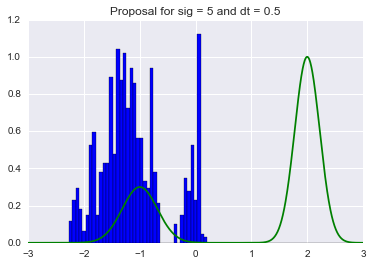

Acceptance Rate =  37.4 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.75


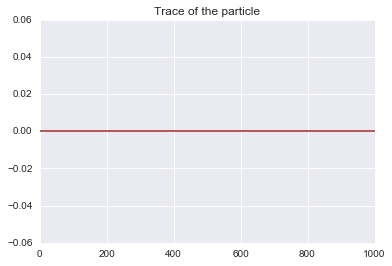

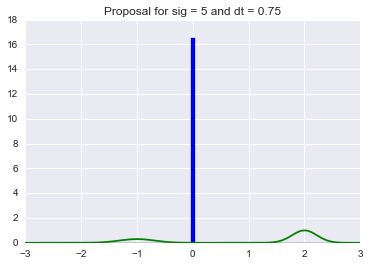

Acceptance Rate =  0.0 %


In [19]:
# Check a few values to see if we can determine trends on what works best
for sig in [1, 2, 3, 4, 5]:
    for dt in [0.25, 0.5, 0.75]:
        print "\nRunning Hamiltonian MCMC with Variance ", sig, " and Timestep ", dt
        run_hmc(sig, dt)
        
# Running this experiment, we notice that sigma should probably be between
# 2 and 5, and dt should be less than 0.5


Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.1


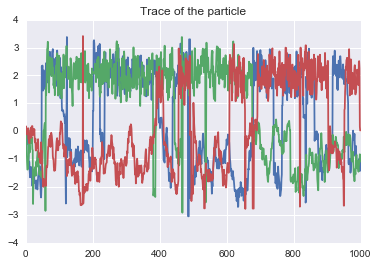

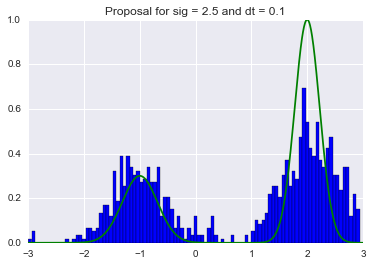

Acceptance Rate =  92.5 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.2


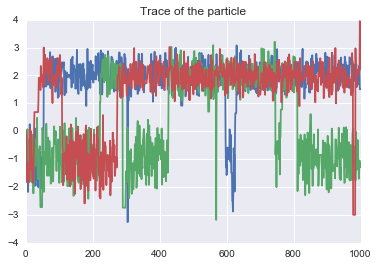

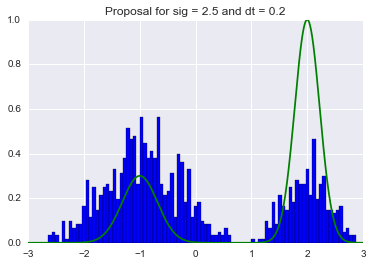

Acceptance Rate =  77.7 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.225


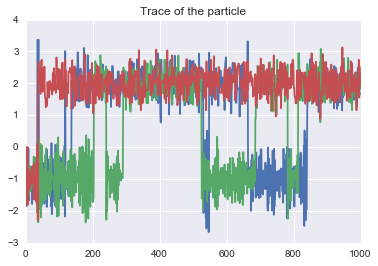

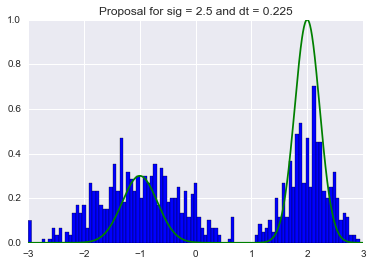

Acceptance Rate =  77.7 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.25


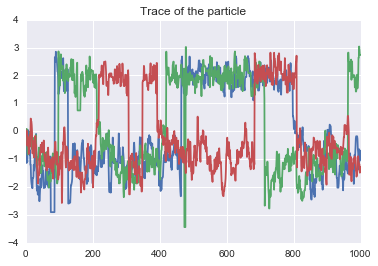

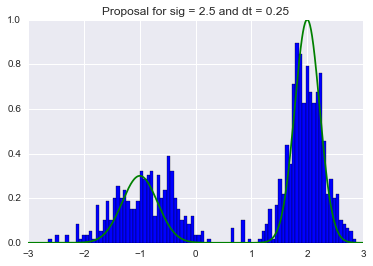

Acceptance Rate =  72.9 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.275


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


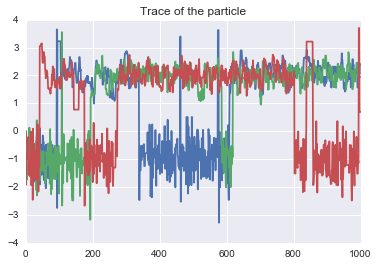

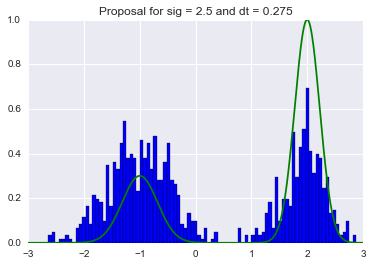

Acceptance Rate =  70.9 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.3


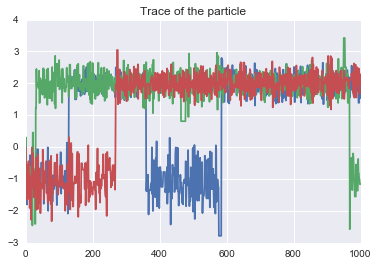

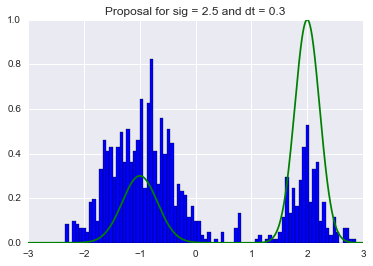

Acceptance Rate =  66.0 %

Running Hamiltonian MCMC with Variance  2.5  and Timestep  0.4


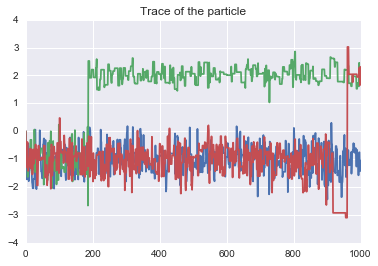

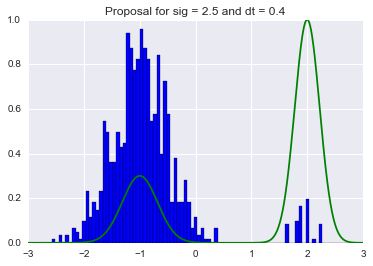

Acceptance Rate =  49.4 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.1


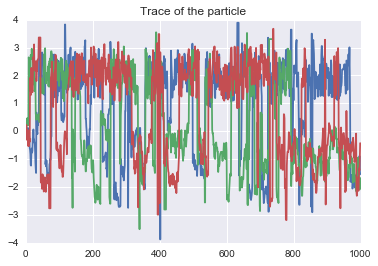

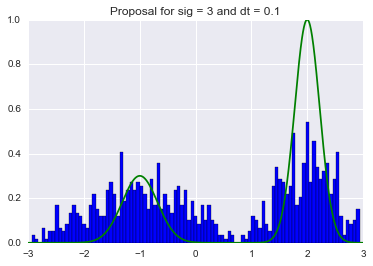

Acceptance Rate =  89.4 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.2


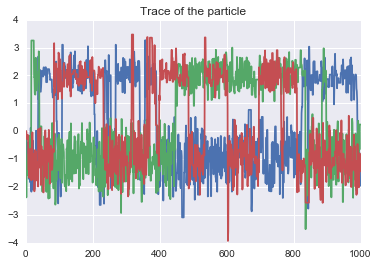

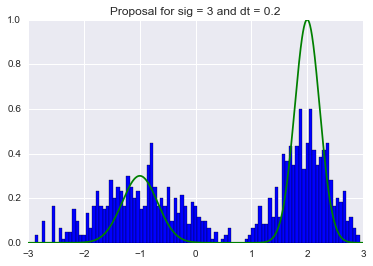

Acceptance Rate =  69.7 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.225


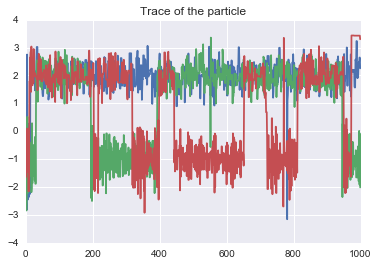

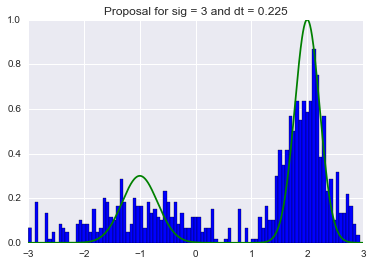

Acceptance Rate =  69.0 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.25


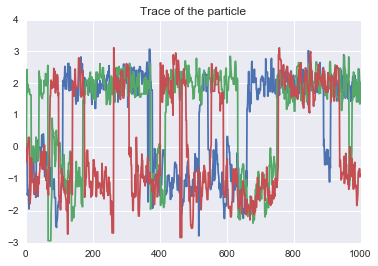

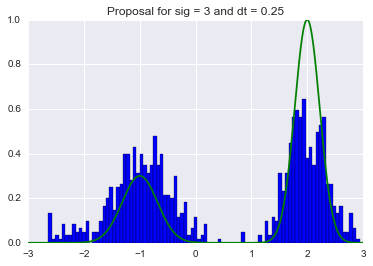

Acceptance Rate =  72.5 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.275


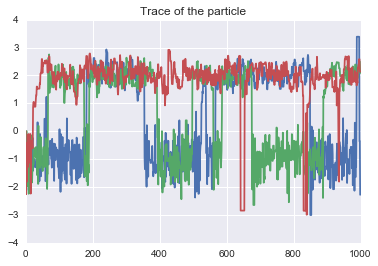

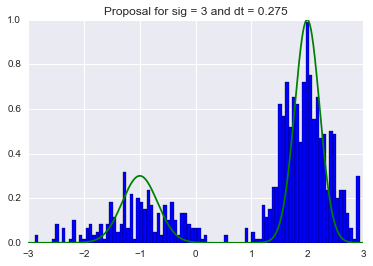

Acceptance Rate =  63.2 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.3


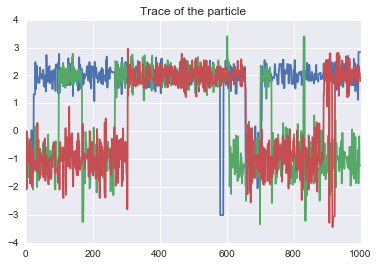

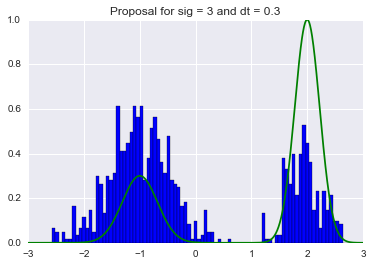

Acceptance Rate =  58.3 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.4


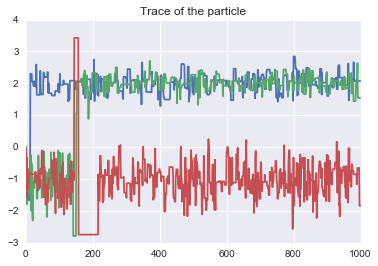

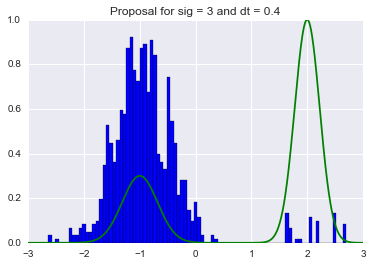

Acceptance Rate =  49.0 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.1


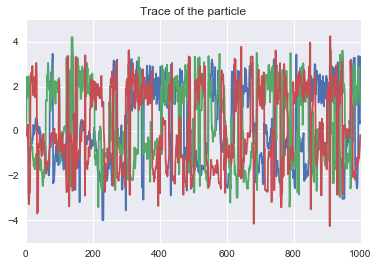

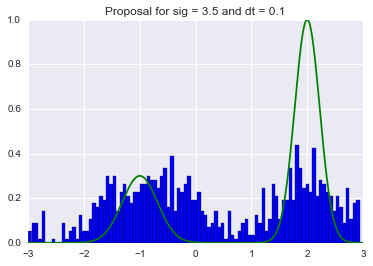

Acceptance Rate =  86.4 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.2


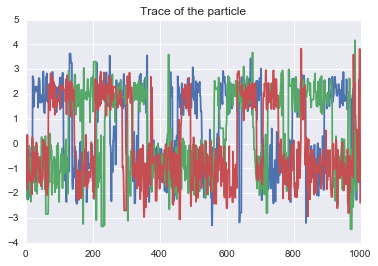

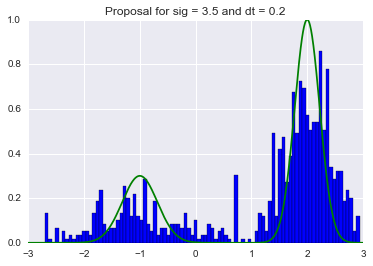

Acceptance Rate =  62.2 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.225


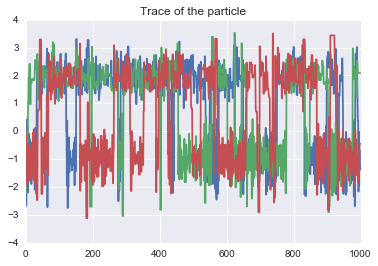

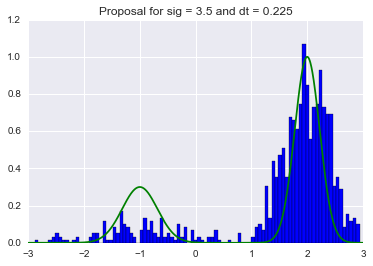

Acceptance Rate =  58.6 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.25


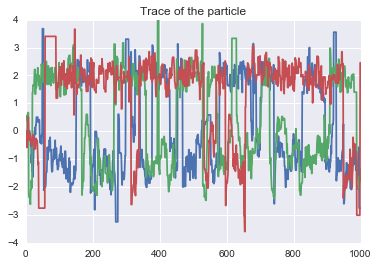

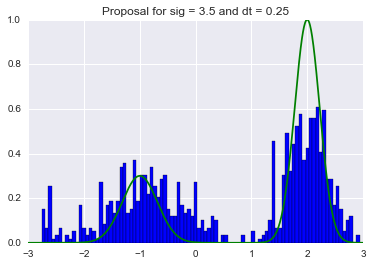

Acceptance Rate =  64.5 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.275


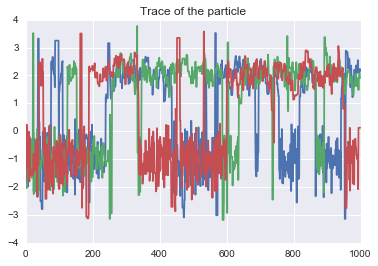

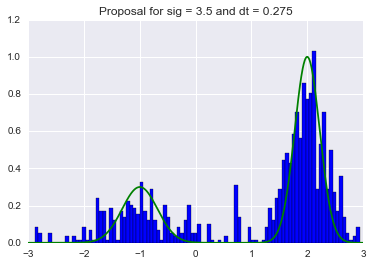

Acceptance Rate =  58.9 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.3


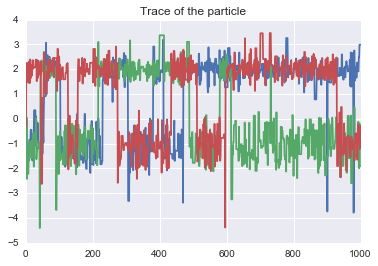

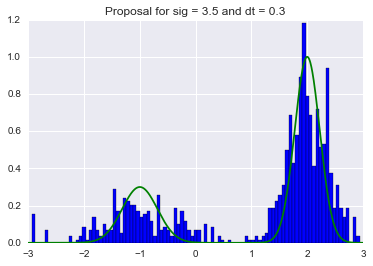

Acceptance Rate =  54.5 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.4


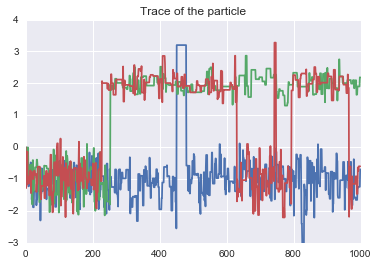

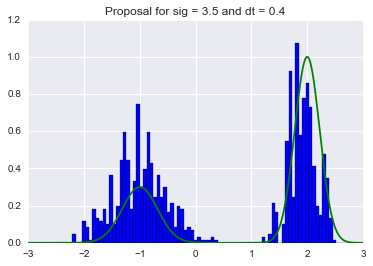

Acceptance Rate =  31.9 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.1


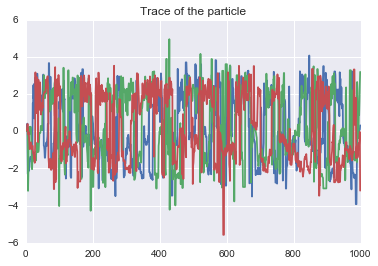

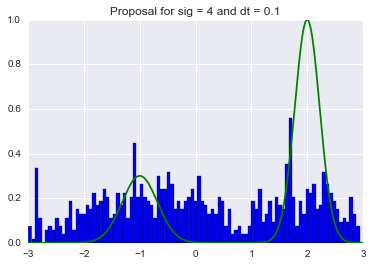

Acceptance Rate =  77.5 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.2


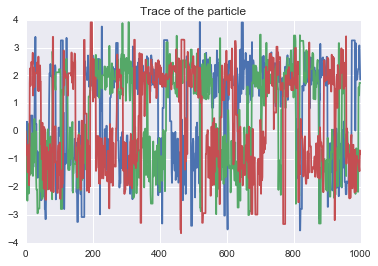

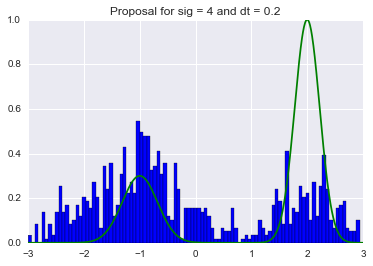

Acceptance Rate =  63.2 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.225


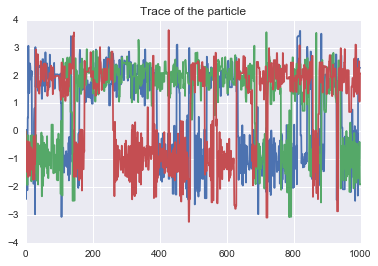

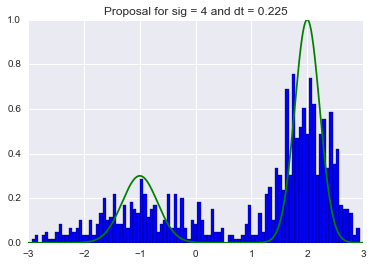

Acceptance Rate =  59.7 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.25


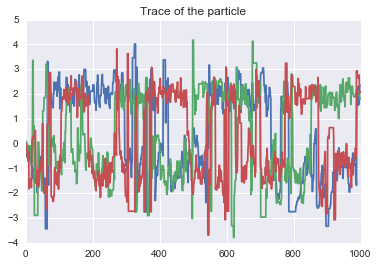

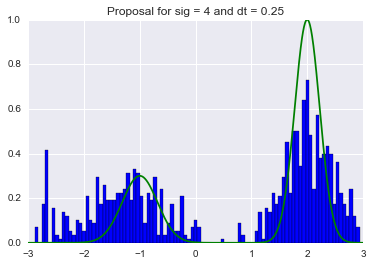

Acceptance Rate =  58.9 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.275


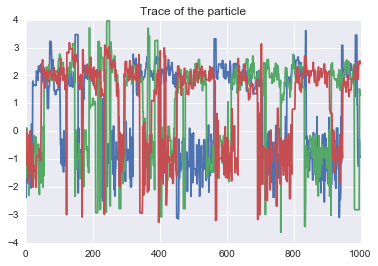

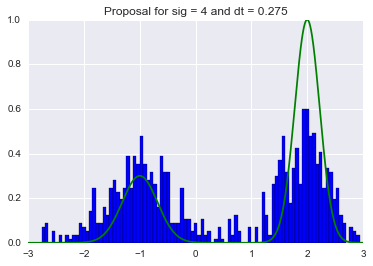

Acceptance Rate =  55.4 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.3


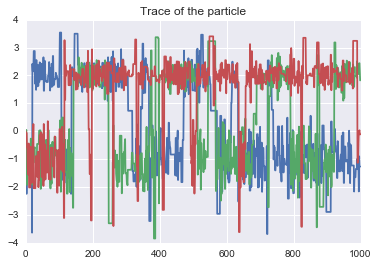

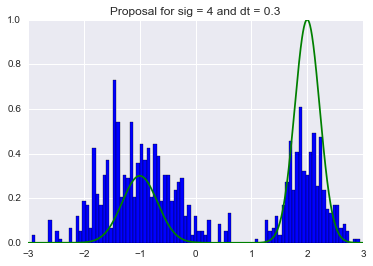

Acceptance Rate =  50.5 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.4


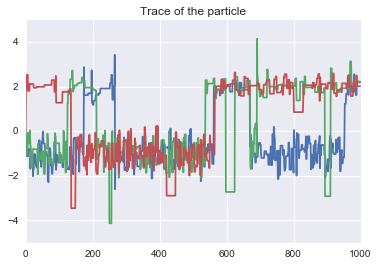

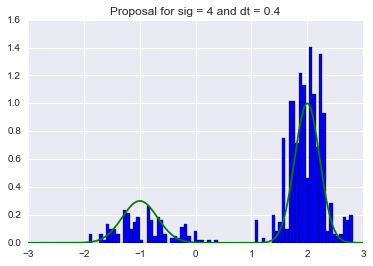

Acceptance Rate =  21.7 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.1


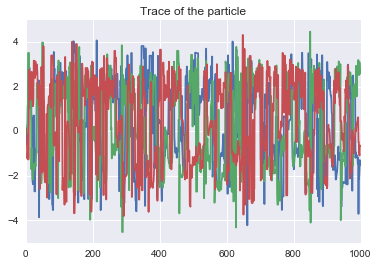

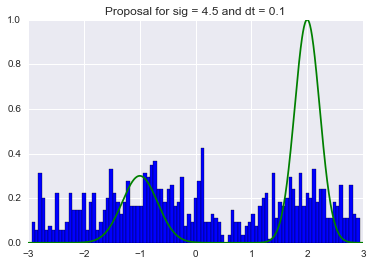

Acceptance Rate =  76.7 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.2


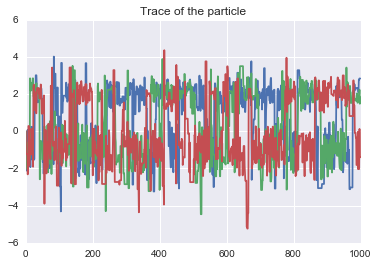

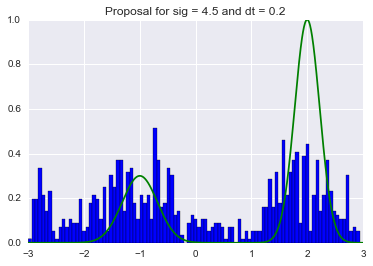

Acceptance Rate =  54.4 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.225


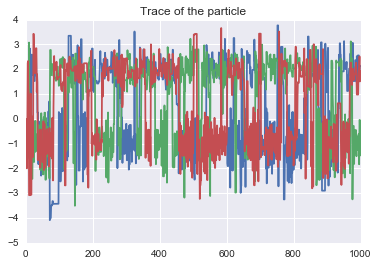

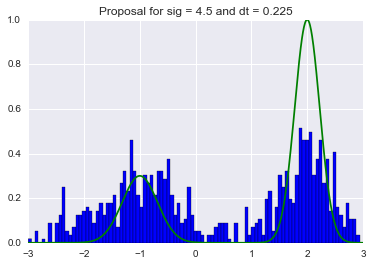

Acceptance Rate =  59.6 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.25


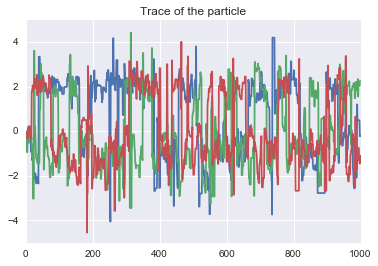

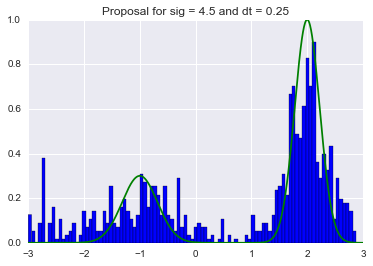

Acceptance Rate =  51.6 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.275


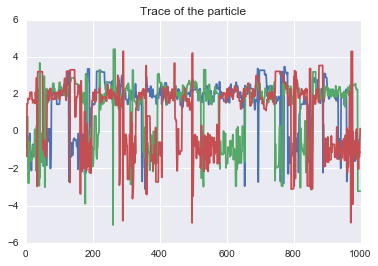

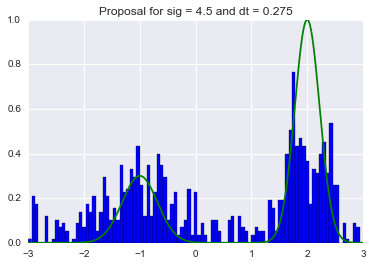

Acceptance Rate =  52.3 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.3


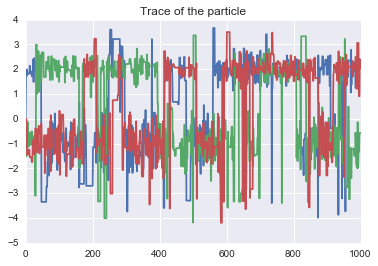

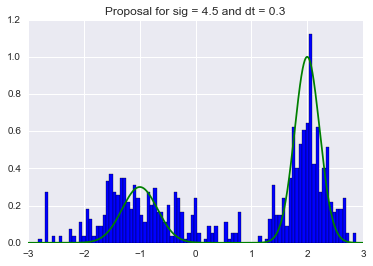

Acceptance Rate =  42.7 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.4


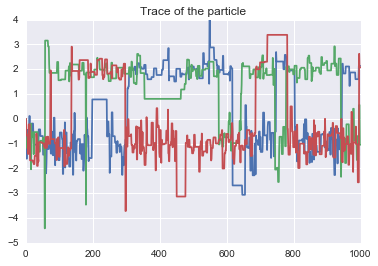

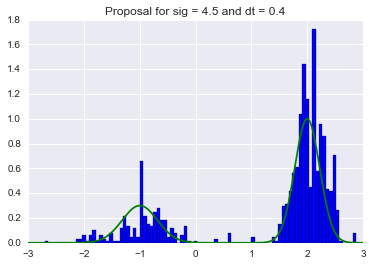

Acceptance Rate =  19.9 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.1


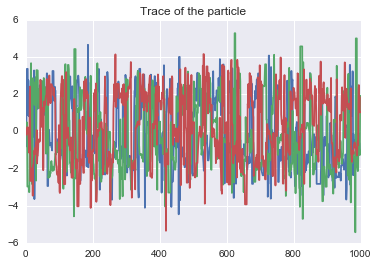

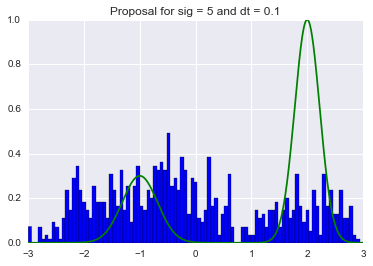

Acceptance Rate =  76.1 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.2


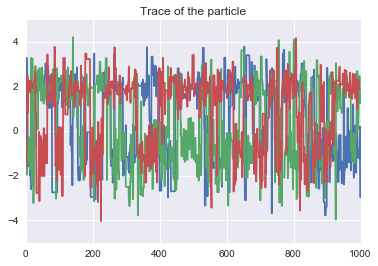

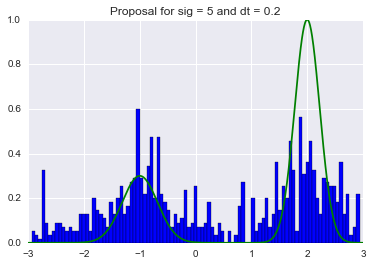

Acceptance Rate =  53.8 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.225


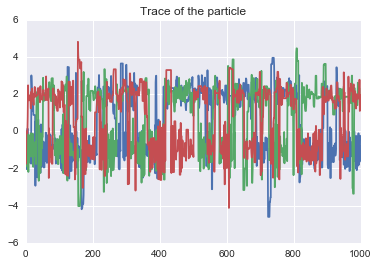

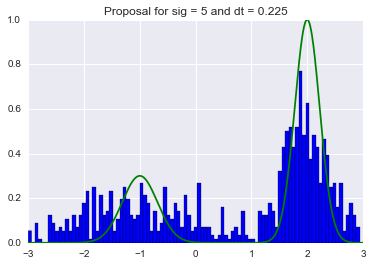

Acceptance Rate =  58.4 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.25


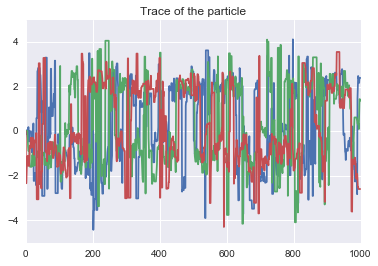

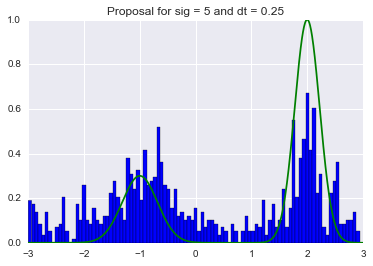

Acceptance Rate =  57.0 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.275


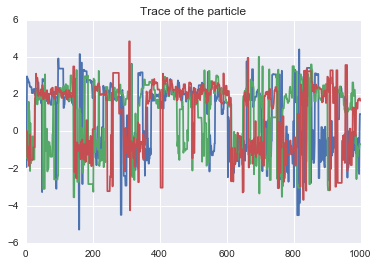

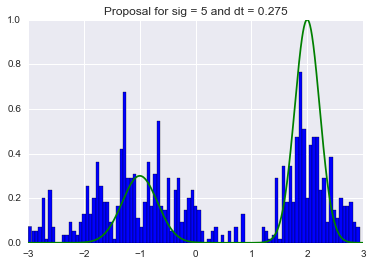

Acceptance Rate =  48.3 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.3


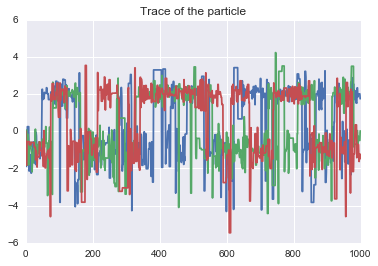

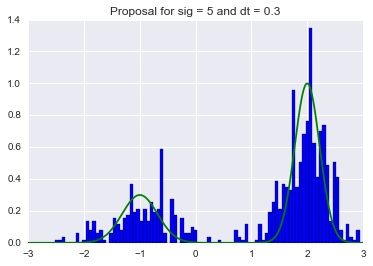

Acceptance Rate =  42.3 %

Running Hamiltonian MCMC with Variance  5  and Timestep  0.4


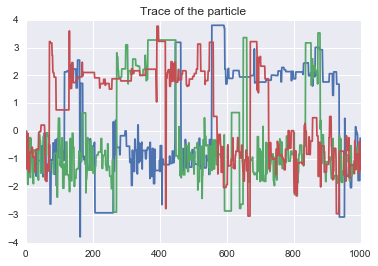

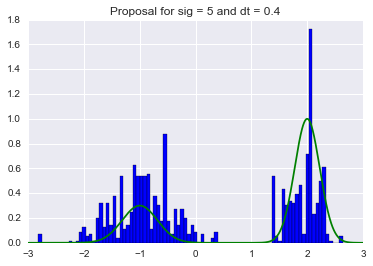

Acceptance Rate =  22.0 %


In [20]:
# Narrow in a bit on the values that seemed to work well before
for sig in [2.5,3,3.5,4,4.5,5]:
    for dt in [0.1,0.2,0.225,0.25,0.275,0.3,0.4]:
        print "\nRunning Hamiltonian MCMC with Variance ", sig, " and Timestep ", dt
        run_hmc(sig, dt)
        
# 0.1 is definitely too small and 0.4 is definitely too big for dt


Running Hamiltonian MCMC with Variance  3  and Timestep  0.25


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars


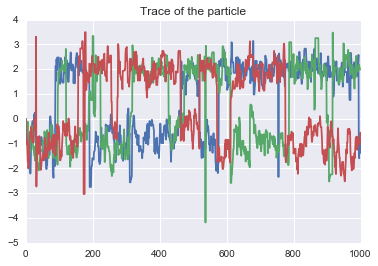

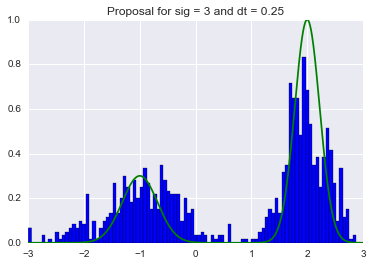

Acceptance Rate =  71.3 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.25


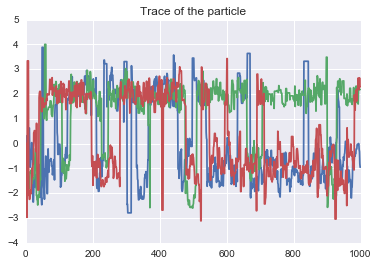

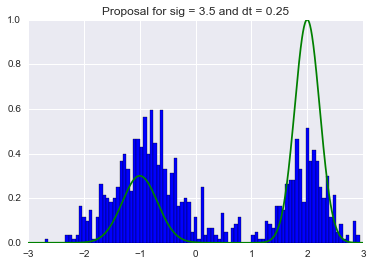

Acceptance Rate =  69.5 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.25


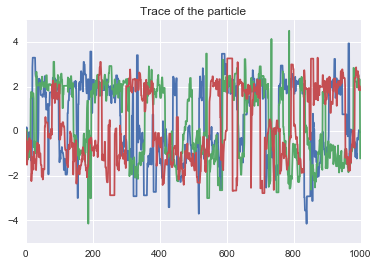

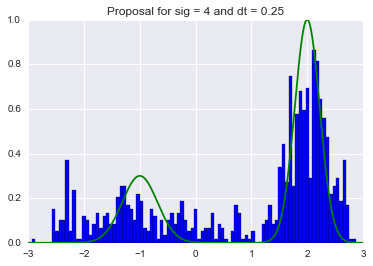

Acceptance Rate =  56.6 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.25


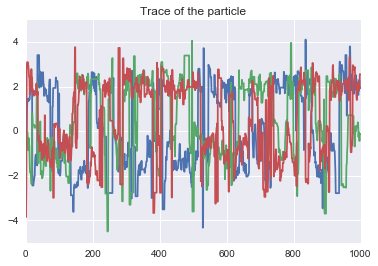

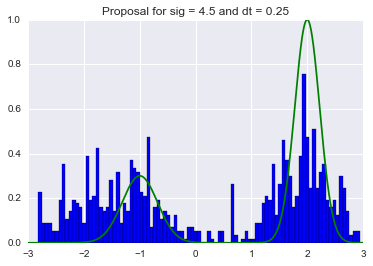

Acceptance Rate =  54.2 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.275


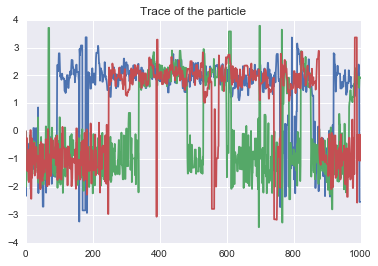

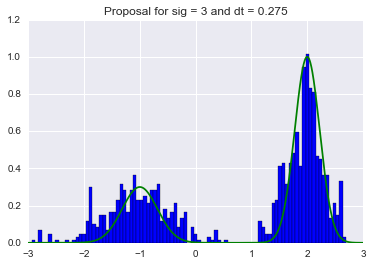

Acceptance Rate =  67.2 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.275


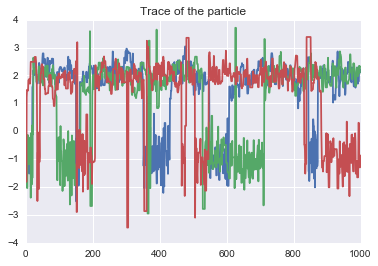

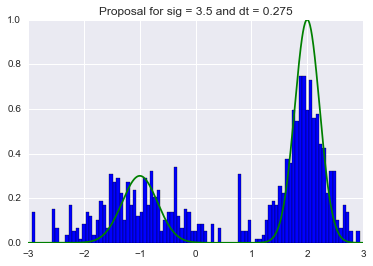

Acceptance Rate =  62.4 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.275


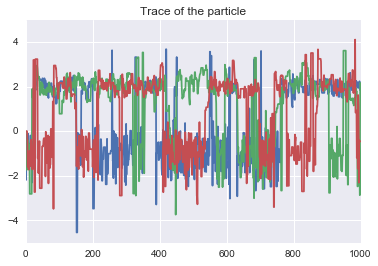

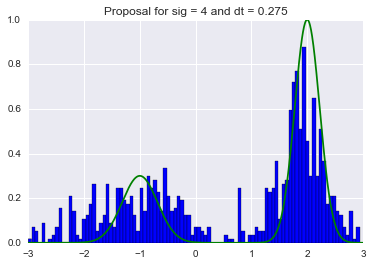

Acceptance Rate =  55.3 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.275


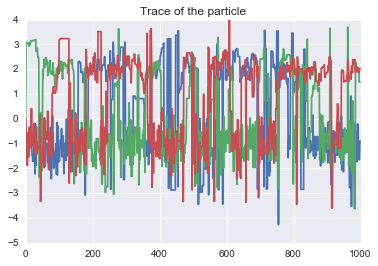

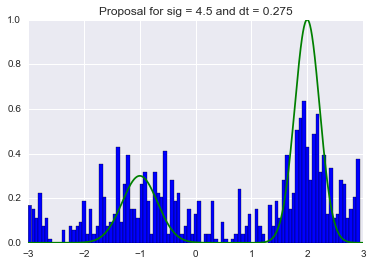

Acceptance Rate =  49.6 %

Running Hamiltonian MCMC with Variance  3  and Timestep  0.3


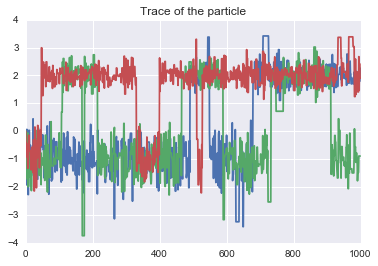

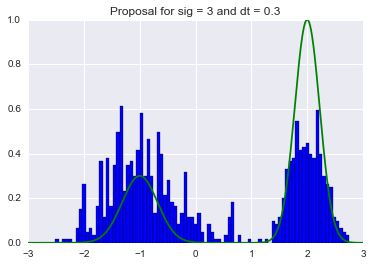

Acceptance Rate =  60.5 %

Running Hamiltonian MCMC with Variance  3.5  and Timestep  0.3


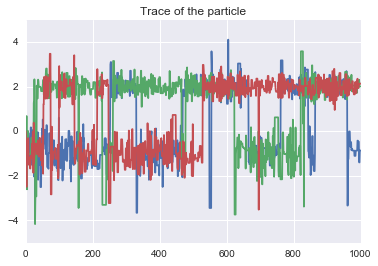

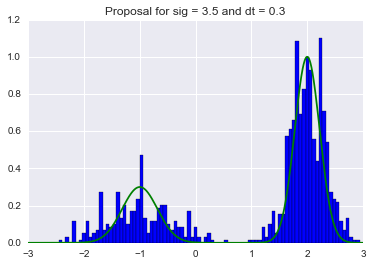

Acceptance Rate =  51.2 %

Running Hamiltonian MCMC with Variance  4  and Timestep  0.3


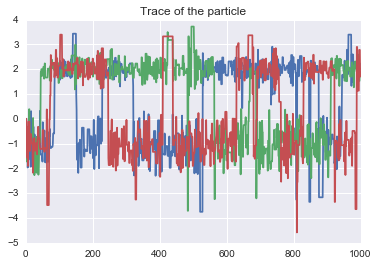

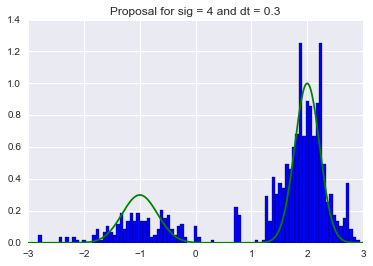

Acceptance Rate =  47.9 %

Running Hamiltonian MCMC with Variance  4.5  and Timestep  0.3


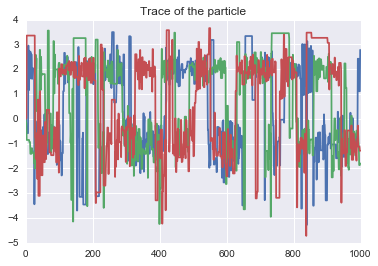

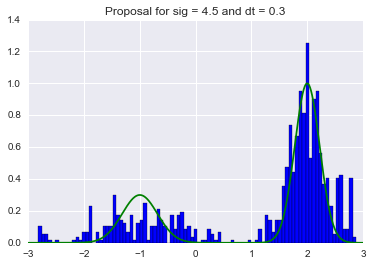

Acceptance Rate =  43.3 %


In [21]:
"""
(I ran these before, but stupidly ran it again with too high of L and it's taking
forever so I'm just turning it in)

Notes

sig = 2.5, dt = 0.1
    Didn't get stuck in a mode, but too flat-ish and not enough on big hump

sig = 2.5, dt = 0.2
    Too much on big hump, not enough little. Gets stuck too easily.
    
sig = 2.5, dt = 0.225
    Looks pretty good! Only switched humps once though, so gets stuck too easily
    
sig = 2.5, dt = 0.25
    Still stuck too easily
    
Overall, sig = 2.5 seems to just get stuck too easily. Too small of a variance.

sig = 3 has a nice amount of switching back and forth
    dt = 0.275 and 0.3 are looking most promising
    
sig = 3.5
    dt = 0.275 is looking fairly decent
    
sig = 4
    0.225 looks fairly good
    So does 0.275
    
sig = 4.5
    dt = 0.1 is way too switchy
    0.3 looks fairly good
    
sig = 5 is getting way too wiggly
"""

# Now try even fewer
for dt in [0.25, 0.275, 0.3]:
    for sig in [3, 3.5, 4, 4.5]:
        print "\nRunning Hamiltonian MCMC with Variance ", sig, " and Timestep ", dt
        run_hmc(sig, dt)

In [ ]:
"""
More Notes

For dt = 0.25, sig = 3.5 and sig = 4 were best

For dt = 0.275, sig = 3 and sig = 3.5 were best

For dt = 0.3, 3.5 worked well
"""